This notebook contains python codes to run strontium isotope box model

In [1]:
# import python module
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Functions
# ---------
# Isotopic mass balace equation
def simSr(jr, rr, rsw, jh, rh, n):
    """

    Strontium isotopic mass balance.

    Parameters
    ----------
    jr : float
        Global riverine flux of Sr
    rr : float
        Strontium isotopic ratio of global riverine flux.
    rsw : float
        Strontium isotopic ratio of seawater.
    jh : float
        Hydrothermal flux of Sr.
    rh : float
        Strontium isotopic ratio of hydrothermal flux (jh).
    n : float
        Strontium reservoir size of the ocean.

    Returns
    -------
    rSr : float
        Strontium isotopic ratio of seawater.

    """
    rSr = (jr*(rr-rsw) + jh*(rh-rsw)) / n
    return rSr

# Function to run model
def run_sim(nt, dt, age, jr, rr, rsw, jh, rh, n):
    """
    
    Solving diff. equations defined in simSr() using the forward Euler method.

    Parameters
    ----------
    nt : int
        number of time steps to run model
    dt : float
        the size of each time step
    age : float
        age in million years
    jr : float
        Global riverine flux of Sr
    rr : float
        Strontium isotopic ratio of global riverine flux.
    rsw : float
        Strontium isotopic ratio of seawater.
    jh : float
        Hydrothermal flux of Sr.
    rh : float
        Strontium isotopic ratio of hydrothermal flux (jh).
    n : float
        Strontium reservoir size of the ocean.

    Returns
    -------
    rSw : float
        Strontium isotopic ratio of seawater.
    grad : float
          gradient of rSw  
        
    """
    rsw0 = (jr[0]*rr[0] + jh[0]*rh[0])/(jr[0]+jh[0])
    rsw[0] = rsw0
    
    for i in range(nt-1):
        rsw[i+1] = rsw[i] + simSr(jr[i], rr[i], rsw[i], jh[i], rh[i], n[i])*dt
    
    grad = np.diff(rsw)/np.diff(age)
    grad = np.append(grad, grad[-1])
   
    return rsw, grad

### Define time
This block of code creates arrays to run the simulation.

In [3]:
# Define array of time
# --------------------
tmin = 487      # ~ base of Ordovician in Ma (GTS2020)
tmax = 443      # ~ base of Silurian in Ma (GST2020)
nt = 100000     # number of steps
dt = (tmin - tmax)*1e6 / nt    # size of each step
time = np.linspace(0, (tmin-tmax)*1e6, nt)    # time array
age = np.linspace(tmin, tmax, nt)             # age array (in Myr)

In [4]:
# Initial values and paramaters
# -----------------------------
# Riverine flux
Jriv0 = 2.5e10
Jriv = np.ones(nt) * Jriv0

# Riverine isotopic ratio
Rriv0 = 0.7119
Rriv = np.ones(nt) * Rriv0

# Axial (crestal) hydrothermal flux
Jhcrest0 = 9.00e9
Jhcrest = np.ones(nt) * Jhcrest0

# Off-axis (flank) hydrothermal flux
Jhflank0 = 3.4e9
Jhflank = np.ones(nt) * Jhflank0

# Total hydrothermal flux
Jh0 = Jhflank0 + Jhcrest0
Jh = np.zeros(nt)
Jh = Jhflank + Jhcrest

# Hydrothermal isotopic ratio
Rh0 = 0.7030
Rh = np.ones(nt) * Rh0

# Array to store isotopic ratio of seawater and rate of change
Rsw = np.zeros(nt)
GradSr = np.zeros(nt)

# Reservoir size
N = np.ones(nt) * 1.9e17

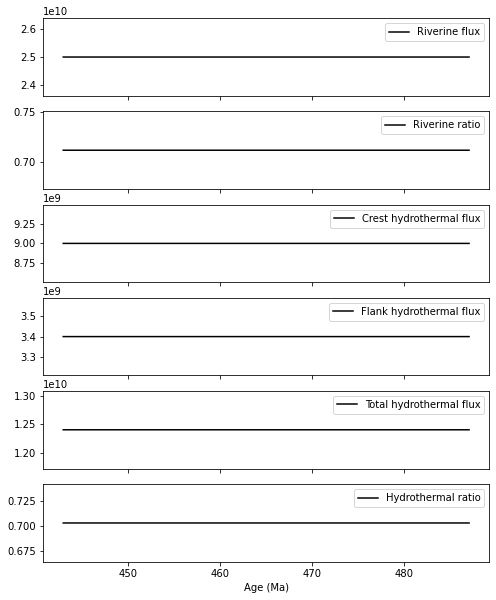

In [5]:
fig, ax = plt.subplots(6, figsize=(8,10), sharex=True)

params = {
    'Riverine flux':Jriv, 
    'Riverine ratio':Rriv, 
    'Crest hydrothermal flux':Jhcrest, 
    'Flank hydrothermal flux':Jhflank,
    'Total hydrothermal flux':Jh,
    'Hydrothermal ratio':Rh}

for index, (key, value), in enumerate(params.items()):
    ax[index].plot(age, value, c='k',label=key)
    ax[index].legend(loc='upper right')
    ax[-1].set_xlabel('Age (Ma)')

plt.savefig("../Figure/params.png")
plt.savefig("../Figure/params.svg")

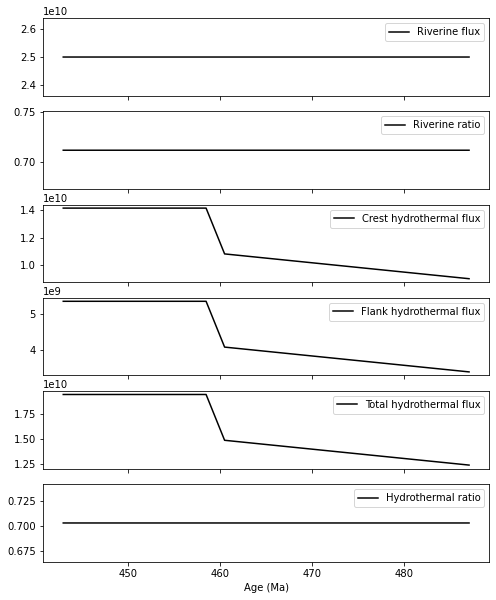

In [6]:
# System perturbation
# -------------------
# timing of perturbation in Ma
start_age = 460 #i.e. the inflection point
stop_age = 458 #where the flux stabilizes into a new baseline

# convert age to array index
start = np.where(np.round(age)==start_age)[0][0]
stop = np.where(np.round(age)==stop_age)[0][0]

# perturb the system by increasing hydrothermal flux
f1 = 1.2 #times the baseline
Jhflank[:start] = np.linspace(Jhflank0, Jhflank0*f1, start)
Jhcrest[:start] = np.linspace(Jhcrest0, Jhcrest0*f1, start)

f2 = 1.31 #times the inflection point flux
Jhflank[start:stop] = np.linspace(Jhflank[start-1], Jhflank[start-1]*f2, (stop-start))
Jhflank[stop:] = np.ones(len(Jhflank)-stop) * (Jhflank[stop-1])
Jhcrest[start:stop] = np.linspace(Jhcrest[start-1], Jhcrest[start-1]*f2, (stop-start))
Jhcrest[stop:] = np.ones(len(Jhcrest)-stop) * (Jhcrest[stop-1])

Jh = Jhflank + Jhcrest

params = {
    'Riverine flux':Jriv, 
    'Riverine ratio':Rriv, 
    'Crest hydrothermal flux':Jhcrest, 
    'Flank hydrothermal flux':Jhflank,
    'Total hydrothermal flux':Jh,
    'Hydrothermal ratio':Rh}

fig, ax = plt.subplots(len(params), figsize=(8,10), sharex=True)
for index, (key, value), in enumerate(params.items()):
    ax[index].plot(age, value, c='k',label=key)
    ax[index].legend(loc='upper right')
    ax[-1].set_xlabel('Age (Ma)')

plt.savefig("../Figure/Params_perturbed.png")
plt.savefig("../Figure/Params_perturbed.svg")

In [7]:
# Run the model
# -------------
Rsw, GradSr = run_sim(nt, dt, age, Jriv, Rriv, Rsw, Jh, Rh, N)

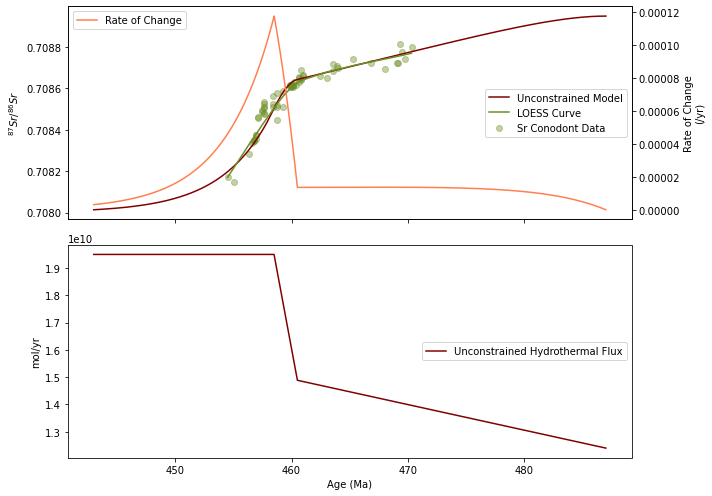

In [8]:
# Load sr measurement for comparison
SrOrdo = pd.read_csv('../Data/Arbuckle_Sr.csv')
loess = pd.read_csv('../Data/Srloess_R.csv')

# plot the result
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7), sharex=True)
ax1.plot(age, Rsw, c='maroon', label="Unconstrained Model")
ax1.plot(loess['age'], loess['loess'], c='olivedrab', label='LOESS Curve')
ax1.scatter(SrOrdo['Age20'], SrOrdo['Sr'], c='olivedrab', label='Sr Conodont Data', alpha=0.4)
ax1.set_ylabel('$^{87}Sr/^{86}Sr$')
ax1.legend(loc='right')

ax1b = ax1.twinx()
ax1b.plot(age, GradSr, color='coral',label='Rate of Change')
ax1b.set_ylabel('Rate of Change\n(/yr)')
ax1b.legend(loc='upper left')

ax2.plot(age, Jh, c='maroon',label='Unconstrained Hydrothermal Flux')
ax2.set_ylabel('mol/yr')
ax2.set_xlabel('Age (Ma)')
ax2.legend(loc='right')

plt.tight_layout()
plt.savefig('../Figure/OrdovicianSr.png')
plt.savefig('../Figure/OrdovicianSr.svg')
plt.show()

### Constraining changes in hydrothermal activities using long-term sea-level change

In this model we hypothesize a role for hydrothermal activities in perturbing global Sr cycles during the Ordovician. To model changes in hydrothermal activities we used eustatic sea level curves, assuming the long-term changes in sea levels are mainly controlled by changes in ocean basin geometry, which in turn depends on the rate of sea floor spreading.

Sea level curves were taken from Haq and Schutter (2008), and recalibrated to Geologic Time Scale 2020 (Goldman et al., 2020).

In [89]:
# load sea level data
ordosealevel = np.load("../Data/OrdoSeaLevel.npz")['SeaLevel']
ordoseaage = np.load("../Data/OrdoSeaLevel.npz")['age']

array size = 100000


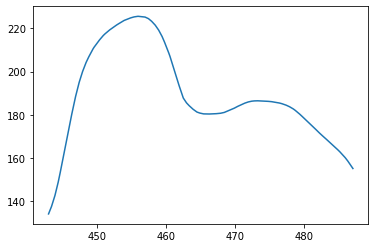

In [91]:
# resample data to fit our modeling array
from scipy import interpolate

f = interpolate.interp1d(ordoseaage, ordosealevel)

sealevel = f(age)
plt.plot(age, sealevel)
print('array size =',len(sealevel))

max  : 1.1895410044394652
min  : 0.7076082562455919
mean : 1.0


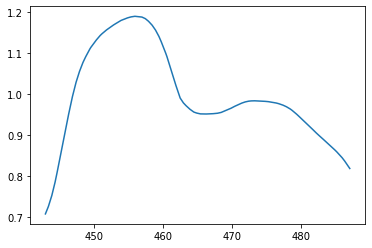

In [92]:
# normalize sea level relative to mean
sl_norm = sealevel / sealevel.mean()

plt.plot(age, sl_norm)
print('max  :', sl_norm.max())
print('min  :', sl_norm.min())
print('mean :', sl_norm.mean())

In [93]:
Jh_sl = sl_norm * Jh0

In [94]:
Rsw_sl = np.zeros(nt)
Rsw_sl, GradSr_sl = run_sim(nt, dt, age, Jriv, Rriv, Rsw_sl, Jh_sl, Rh, N)

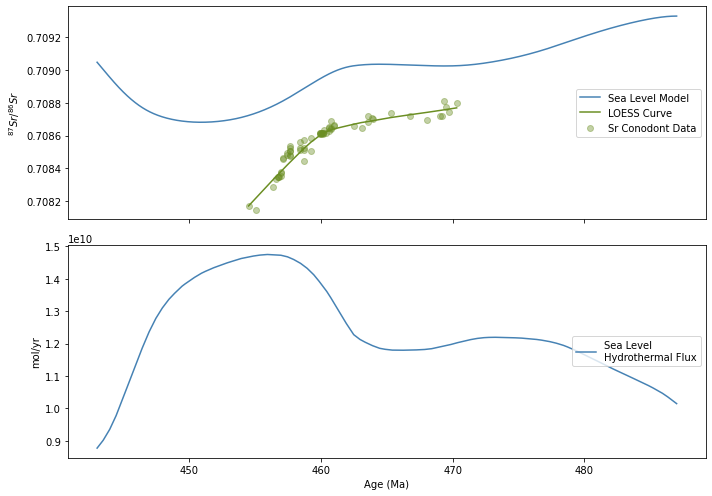

In [95]:
# plot the result
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7), sharex=True)
ax1.plot(age, Rsw_sl, c='steelblue',label="Sea Level Model")
ax1.plot(loess['age'], loess['loess'], c='olivedrab', label='LOESS Curve')
ax1.scatter(SrOrdo['Age20'], SrOrdo['Sr'], c='olivedrab', label='Sr Conodont Data', alpha=0.4)
ax1.set_ylabel('$^{87}Sr/^{86}Sr$')
ax1.legend(loc='right')

ax2.plot(age, Jh_sl, c='steelblue',label='Sea Level\nHydrothermal Flux')
ax2.set_ylabel('mol/yr')
ax2.set_xlabel('Age (Ma)')
ax2.legend(loc='right')

plt.tight_layout()
plt.savefig('../Figure/OrdovicianSr_sealevel.png')
plt.savefig('../Figure/OrdovicianSr_sealevel.svg')
plt.show()

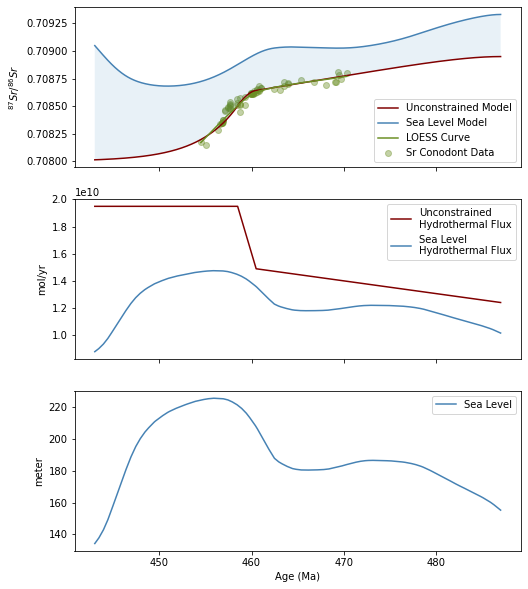

In [96]:
fig, ax = plt.subplots(3, figsize=(8, 10), sharex=True)

ax[0].plot(age, Rsw, c='maroon', label="Unconstrained Model")
ax[0].plot(age, Rsw_sl, c='steelblue', label="Sea Level Model")
ax[0].plot(loess['age'], loess['loess'], c='olivedrab', label='LOESS Curve')
ax[0].scatter(SrOrdo['Age20'], SrOrdo['Sr'], c='olivedrab', label='Sr Conodont Data', alpha=0.4)
ax[0].fill_between(age, Rsw_sl, Rsw, alpha=0.1)
ax[0].set_ylabel('$^{87}Sr/^{86}Sr$')
ax[0].legend(loc='best')

ax[1].plot(age, Jh, c='maroon',label='Unconstrained\nHydrothermal Flux')
ax[1].plot(age, Jh_sl,  c='steelblue',label='Sea Level\nHydrothermal Flux')
ax[1].set_ylabel('mol/yr')
ax[1].legend(loc='best')

ax[2].plot(age, sealevel,  c='steelblue', label='Sea Level')
ax[2].set_ylabel('meter')
ax[2].set_xlabel('Age (Ma)')
ax[2].legend(loc='best')

plt.savefig('../Figure/OrdovicianSr_compare.png')
plt.savefig('../Figure/OrdovicianSr_compare.svg')
plt.show()

## Taconic Flux
Add sr flux from Taconic weathering. Flux magnitude are based on fluxes in Nd isotopic model from Conwell et al (2021). We convert Nd flux (mol/yr) to Sr flux (mol/yr) using this equation:

$$Sr_{flux} = Nd_{flux} \times \frac{A_{Nd}}{A_{Sr}} \times \frac{[Sr]_{ppm}}{[Nd]_{ppm}}$$

where:

$Sr_{flux} = $ Strontium flux associated with the Taconic weathering in mol/yr

$Nd_{flux} = $ Neodymium flux associated with the Taconic weathering in mol/yr (Conwell et al, 2021)

$A_{Nd} = $ Atomic mass of Nd

$A_{Sr} = $ Atomic mass of Sr

$[Sr]_{ppm} = $ Sr concentration in basaltic rocks (from Faure and Mensing (2009))

$[Nd]_{ppm} = $ Nd concentration in basaltic rocks (from Faure and Mensing (2009))

In [97]:
# load Nd flux
Ndflux = np.load('../Data/NdBasaltTaconic.npy')

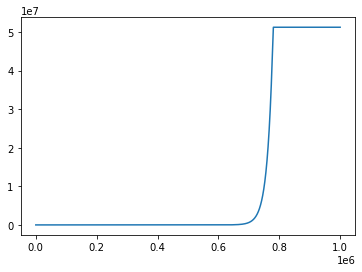

In [98]:
plt.plot(Ndflux)

Because the array size and the timing of the perturbation are slightly different, we need to restructure / remake the array to fit our model.

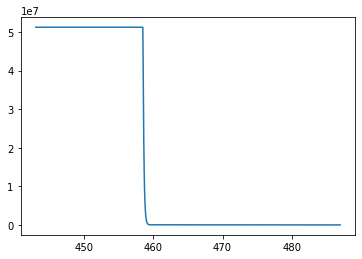

In [99]:
# Get min max value of Ndflux
Ndmax = Ndflux.max()
Ndmin = Ndflux.min()

# Generate new Ndflux
JNd = np.ones(nt) * Ndmin
JNd[start:stop] = np.geomspace(Ndmin, Ndmax, (stop-start))
JNd[stop:] = Ndmax

plt.plot(age, JNd)

In [100]:
# Geochemical parameters

# Basalt chemistry compiled by Faure (1991)
bst_cCa = 72000  # Ca concentration in basalt (ppm)
bst_cSr = 452    # Sr concentration in basalt (ppm)
bst_cNd = 14     # Nd concentration in basalt (ppm)

# Atomic / Molecular masses
A_Ca = 40.078    # Ca atomic mass
A_Sr = 87.62     # Sr atomic mass
A_Nd = 144.242   # Nd atomic mass
A_C = 12.011     # C atomic mass
A_O = 15.999     # O atomic mass
A_CO2 = A_C + 2*A_O     # CO2 molecular mass

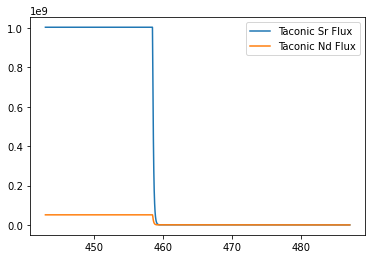

In [101]:
Jtaconic = JNd * (A_Sr/A_Nd) * (bst_cSr/bst_cNd)
Rtaconic = np.ones(nt) * 0.7030

plt.plot(age, Jtaconic, label='Taconic Sr Flux')
plt.plot(age, JNd, label='Taconic Nd Flux')
plt.legend()

Define a new set of functions to incorporate Taconic Sr flux

In [102]:
# Functions
# ---------
# Isotopic mass balace equation
def simSr2(jr, rr, rsw, jh, rh, jtaconic, rtaconic, n):
    """

    Strontium isotopic mass balance.

    Parameters
    ----------
    jr : float
        Global riverine flux of Sr
    rr : float
        Strontium isotopic ratio of global riverine flux.
    rsw : float
        Strontium isotopic ratio of seawater.
    jh : float
        Hydrothermal flux of Sr.
    rh : float
        Strontium isotopic ratio of hydrothermal flux (jh).
    jtaconic : float
        Sr flux from Taconic weathering
    rtaconic : float
        Strontium isotpic ratio of taconic weathering
    n : float
        Strontium reservoir size of the ocean.

    Returns
    -------
    rSr : float
        Strontium isotopic ratio of seawater.

    """
    rSr = (jr*(rr-rsw) + jh*(rh-rsw) + jtaconic*(rtaconic-rsw)) / n
    return rSr

# Function to run model
def run_sim2(nt, dt, age, jr, rr, rsw, jh, rh, jtaconic, rtaconic, n):
    """
    
    Solving diff. equations defined in simSr2() using the forward Euler method.

    Parameters
    ----------
    nt : int
        number of time steps to run model
    dt : float
        the size of each time step
    age : float
        age in million years
    jr : float
        Global riverine flux of Sr
    rr : float
        Strontium isotopic ratio of global riverine flux.
    rsw : float
        Strontium isotopic ratio of seawater.
    jh : float
        Hydrothermal flux of Sr.
    rh : float
        Strontium isotopic ratio of hydrothermal flux (jh).
    jtaconic : float
        Sr flux from Taconic weathering
    rtaconic : float
        Strontium isotpic ratio of taconic weathering
    n : float
        Strontium reservoir size of the ocean.

    Returns
    -------
    rSw : float
        Strontium isotopic ratio of seawater.
    grad : float
          gradient of rSw  
        
    """
    rsw0 = (jr[0]*rr[0] + jh[0]*rh[0] + jtaconic[0]*rtaconic[0])/(jr[0]+jh[0]+jtaconic[0])
    rsw[0] = rsw0
    
    for i in range(nt-1):
        rsw[i+1] = rsw[i] + simSr2(jr[i], rr[i], rsw[i], jh[i], rh[i], jtaconic[i], rtaconic[i], n[i])*dt
    
    grad = np.diff(rsw)/np.diff(age)
    grad = np.append(grad, grad[-1])
   
    return rsw, grad

In [103]:
Rsw_taconic = np.zeros(nt)
Rsw_taconic, GradSr_taconic = run_sim2(nt, dt, age, Jriv, Rriv, Rsw_sl, Jh_sl, Rh, Jtaconic, Rtaconic, N)

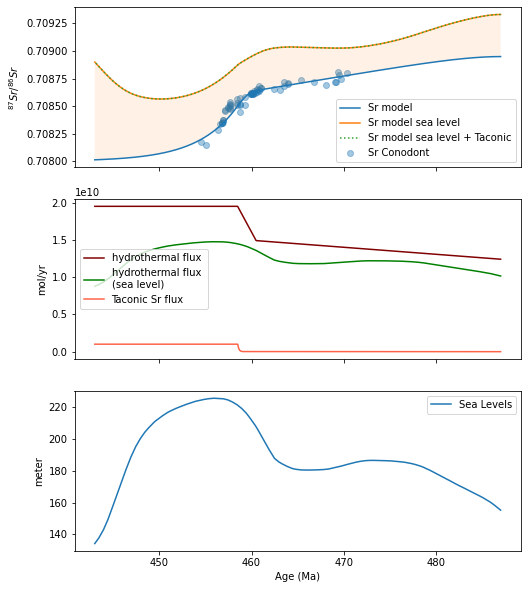

In [104]:
fig, ax = plt.subplots(3, figsize=(8, 10), sharex=True)

ax[0].plot(age, Rsw, label="Sr model")
ax[0].plot(age, Rsw_sl, label="Sr model sea level")
ax[0].plot(age, Rsw_taconic, ls=':', label="Sr model sea level + Taconic")
ax[0].scatter(SrOrdo['Age20'], SrOrdo['Sr'], label='Sr Conodont', alpha=0.4)
ax[0].fill_between(age, Rsw_sl, Rsw, alpha=0.1)
ax[0].set_ylabel('$^{87}Sr/^{86}Sr$')
ax[0].legend(loc='best')

ax[1].plot(age, Jh, c='maroon',label='hydrothermal flux')
ax[1].plot(age, Jh_sl, c='green',label='hydrothermal flux \n(sea level)')
ax[1].plot(age, Jtaconic, c='tomato',label='Taconic Sr flux')
ax[1].set_ylabel('mol/yr')
ax[1].legend(loc='best')

ax[2].plot(age, sealevel, label='Sea Levels')
ax[2].set_ylabel('meter')
ax[2].set_xlabel('Age (Ma)')
ax[2].legend(loc='best')

plt.savefig('../Figure/OrdovicianSr_compare2.png')
plt.savefig('../Figure/OrdovicianSr_compare2.svg')
plt.show()

## Constraining required juvenile flux to fit Sr data
### 1 Steady-State-back-calculation

By making an assumption that during each time step the system behave as a steady state system we can make an estimation of the required juvenile flux to fit the data using this equation:

$$J_{required} = \frac{\sum_{n=1}^{fluxes} J_n R_{mix} - J_n R_n}{R_{required} - R_{mix}}$$

In [105]:
Jjuv = (Jriv*Rsw - Jriv*Rriv + Jh_sl*Rsw - Jh_sl*Rh) / (Rtaconic - Rsw)

In [106]:
Rsw_juv = np.zeros(nt)
Rsw_juv, GradSr_juv = run_sim2(nt, dt, age, Jriv, Rriv, Rsw_juv, Jh_sl, Rh, Jjuv, Rtaconic, N)

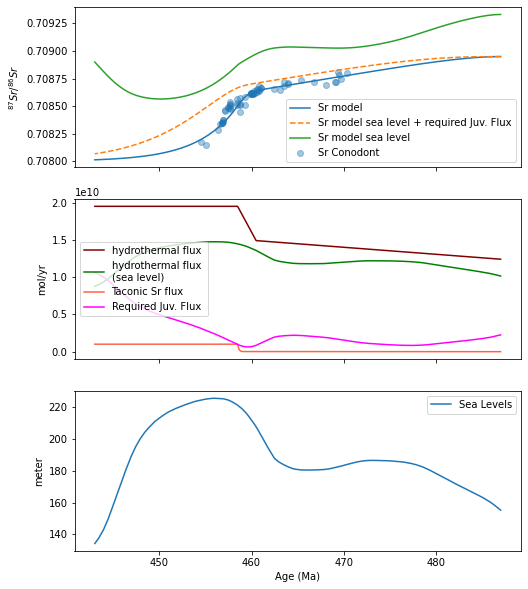

In [107]:
fig, ax = plt.subplots(3, figsize=(8, 10), sharex=True)

ax[0].plot(age, Rsw, label="Sr model")
ax[0].plot(age, Rsw_juv, ls='--', label="Sr model sea level + required Juv. Flux")
ax[0].plot(age, Rsw_sl, label="Sr model sea level")
ax[0].scatter(SrOrdo['Age20'], SrOrdo['Sr'], label='Sr Conodont', alpha=0.4)
ax[0].set_ylabel('$^{87}Sr/^{86}Sr$')
ax[0].legend(loc='best')

ax[1].plot(age, Jh, c='maroon',label='hydrothermal flux')
ax[1].plot(age, Jh_sl, c='green',label='hydrothermal flux \n(sea level)')
ax[1].plot(age, Jtaconic, c='tomato',label='Taconic Sr flux')
ax[1].plot(age, Jjuv, c='magenta',label='Required Juv. Flux')
ax[1].set_ylabel('mol/yr')
ax[1].legend(loc='best')

ax[2].plot(age, sealevel, label='Sea Levels')
ax[2].set_ylabel('meter')
ax[2].set_xlabel('Age (Ma)')
ax[2].legend(loc='best')

plt.savefig('../Figure/OrdovicianSr_compare3.png')
plt.savefig('../Figure/OrdovicianSr_compare3.svg')
plt.show()

### 2 Substraction from basline models
A more straightforward method to estimate the required additional Sr flux to create a model with a better fit is by substracting baseline flux (Jh) with sea level driven hydrothermal flux (Jh_sl). This parameter can potentially be a good estimate of continental basaltic weathering source of Sr (i.e. weathering of basaltic rocks uplifted during the Taconic Orogeny).

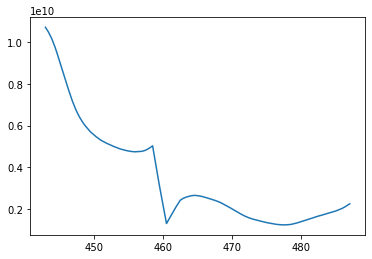

In [108]:
Jreq = Jh - Jh_sl
plt.plot(age, Jreq)

In [109]:
Rsw_req = np.zeros(nt)
Rsw_req, GradSr_req= run_sim2(nt, dt, age, Jriv, Rriv, Rsw_req, Jh_sl, Rh, Jreq, Rtaconic, N)

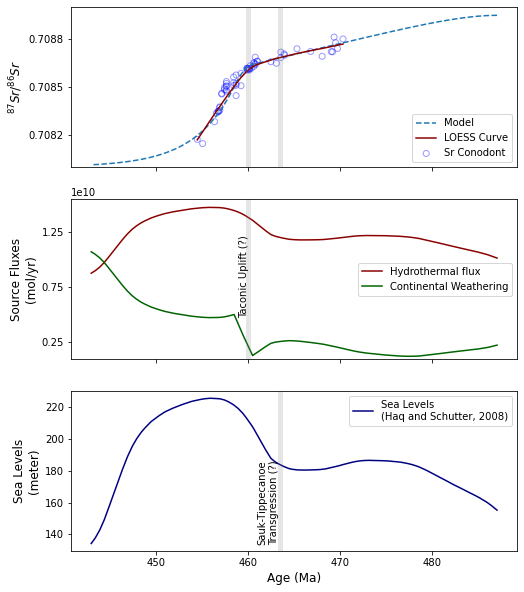

In [155]:
fig, ax = plt.subplots(3, figsize=(8, 10), sharex=True)


ax[0].plot(age, Rsw_req, ls='--', label="Model")
#ax[0].plot(age, Rsw_sl, label="Hydrothermal")
ax[0].scatter(SrOrdo['Age20'], SrOrdo['Sr'], label='Sr Conodont', ec='blue', fc='None' ,alpha=0.4)
ax[0].plot(loess['age'], loess['loess'], c='darkred', label='LOESS Curve')
ax[0].set_ylim(0.7080, 0.7090)
ax[0].set_yticks(np.linspace(0.7082, 0.7088, 3))

ax[0].set_ylabel('$^{87}Sr/^{86}Sr$', fontsize=12)
ax[0].legend(loc='lower right')


ax[1].plot(age, Jh_sl, c='darkred',label='Hydrothermal flux')
ax[1].plot(age, Jreq, c='darkgreen',label='Continental Weathering')
ax[1].set_ylim(0.10e10, 1.55e10)
ax[1].set_yticks(np.linspace(0.25e10, 1.25e10, 3))
ax[1].set_ylabel('Source Fluxes\n(mol/yr)', fontsize=12)
ax[1].legend(loc='center right')

ax[2].plot(age, sealevel, label='Sea Levels\n(Haq and Schutter, 2008)', c='navy')
ax[2].set_ylabel('Sea Levels\n(meter)', fontsize=12)
ax[2].set_xlabel('Age (Ma)', fontsize=12)
ax[2].legend(loc='best')

# Vertical Lines for highlighting
for i in (0,1):
    ax[i].axvline(x=460, c='gray', lw=5, alpha=0.2)

ax[1].text(459, 0.85e10, "Taconic Uplift (?)", va='center',rotation='vertical')

for i in (0,2):
    ax[i].axvline(x=463.5, c='gray', lw=5, alpha=0.2)

ax[2].text(461, 160, "Sauk-Tippecanoe\nTransgression (?)", va='center',rotation='vertical')

plt.savefig('../Figure/OrdovicianSr_compare4.png')
plt.savefig('../Figure/OrdovicianSr_compare4.svg')
plt.show()

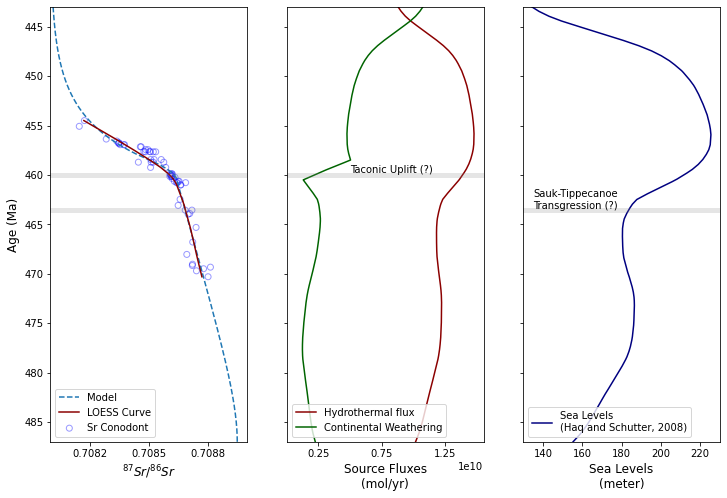

In [160]:
fig, ax = plt.subplots(1,3, figsize=(12, 8), sharey=True)


ax[0].plot(Rsw_req,age, ls='--', label="Model")
ax[0].scatter(SrOrdo['Sr'], SrOrdo['Age20'], label='Sr Conodont', ec="blue",fc="none", alpha=0.4)
ax[0].plot(loess['loess'], loess['age'], c='darkred', label='LOESS Curve')
ax[0].set_xlim(0.7080, 0.7090)
ax[0].set_xticks(np.linspace(0.7082, 0.7088, 3))
ax[0].set_ylim(age.max(), age.min())
ax[0].set_xlabel('$^{87}Sr/^{86}Sr$', fontsize=12)
ax[0].set_ylabel('Age (Ma)', fontsize=12)
ax[0].legend(loc='lower left')

ax[1].plot(Jh_sl, age, c='darkred',label='Hydrothermal flux')
ax[1].plot(Jreq, age, c='darkgreen',label='Continental Weathering')
ax[1].set_xlim(0, 1.55e10)
ax[1].set_xticks(np.linspace(0.25e10, 1.25e10, 3))
ax[1].set_xlabel('Source Fluxes\n(mol/yr)', fontsize=12)
ax[1].legend(loc='lower left')

ax[2].plot(sealevel, age, label='Sea Levels\n(Haq and Schutter, 2008)', c='navy')
ax[2].set_xlabel('Sea Levels\n(meter)', fontsize=12)
ax[2].legend(loc='lower left')

# Vertical Lines for highlighting
for i in (0,1):
    ax[i].axhline(y=460, c='grey', lw=5, alpha=0.2)
    
for i in (0,2):
    ax[i].axhline(y=463.5, c='grey', lw=5, alpha=0.2)
    
ax[1].text(0.50e10, 459.5, "Taconic Uplift (?)", va='center',rotation='horizontal')
ax[2].text(135, 462.5, "Sauk-Tippecanoe\nTransgression (?)", va='center',rotation='horizontal')

plt.savefig('../Figure/OrdovicianSr_compare4_rotate.png')
plt.savefig('../Figure/OrdovicianSr_compare4_rotate.svg')
plt.show()

In [153]:
TaconicIncrease = Jreq[np.where(age>455)].max() - Jreq[np.where(age>455)].min()
Baseline = Jreq[np.where(age>460)].mean()
PercentIncrease1 = TaconicIncrease/Jreq[np.where(age>455)].min() * 100
PercentIncrease2 = (Jreq[np.where(age>455)].max() - Baseline) / Baseline * 100

print("Percent (%) Increase")
print("--------------------")
print("relative to min value = %s " % round(PercentIncrease1))
print("relative to pre-460Ma baseline = %s " % round(PercentIncrease2))

Percent (%) Increase
--------------------
relative to min value = 306 
relative to pre-460Ma baseline = 172 


## Relative Deagassing from COPSE-Reloaded Model

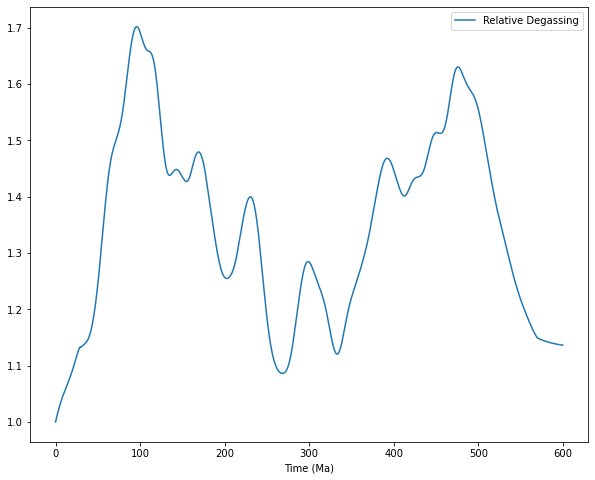

In [112]:
fig, ax = plt.subplots(figsize=(10,8))
degassing = pd.read_excel('../Data/D_haq_inversion_2017.xlsx')
degassing.plot(x='Time (Ma)', y='Relative Degassing', ax=ax)

(443.0, 487.0)

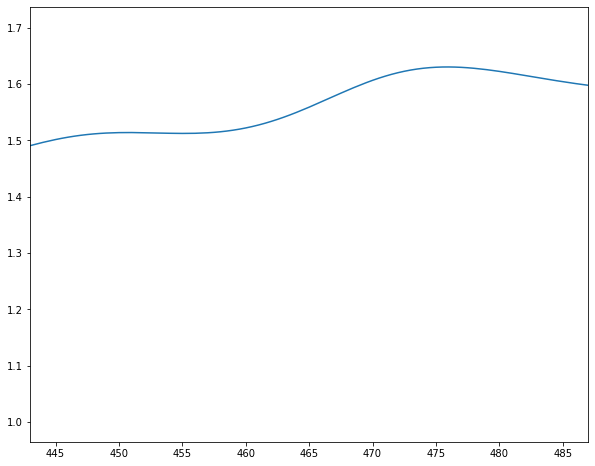

In [113]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(degassing['Time (Ma)'], degassing['Relative Degassing'])
ax.set_xlim(443, 487)